"""
 - data from https://www.kaggle.com/c/indoor-location-navigation
 - data conversion using main_interp_wtime.py based on time of the wifi recordings 
 - these area every 2.2-2.5 seconds, and their position is intyerpolated linearily assuming constant speed between waypoints 
 - BLE beacons are attached to the closes interpolated point 
 - actual waypoint in the data ay not appear in the json produced
"""

indoor_comp_import.png - example of resulted points (blue) 


In [1]:
from utils import *
import sys, os, random

datadir = "../data.upb/uji/"


In [3]:
uji3_fnames=[
"01/3.0uji_month01_trn01.json",
"01/3.0uji_month01_trn02.json",
"01/3.0uji_month01_trn03.json",
"01/3.0uji_month01_trn04.json",
"01/3.0uji_month01_trn05.json",
"01/3.0uji_month01_trn06.json",
"01/3.0uji_month01_trn07.json",
"01/3.0uji_month01_trn08.json",
"01/3.0uji_month01_trn09.json",
"01/3.0uji_month01_trn10.json",
"01/3.0uji_month01_trn11.json",
"01/3.0uji_month01_trn12.json",
"01/3.0uji_month01_trn13.json",
"01/3.0uji_month01_trn14.json",
"01/3.0uji_month01_trn15.json",
"02/3.0uji_month02_trn01.json",
"03/3.0uji_month03_trn01.json",
"04/3.0uji_month04_trn01.json",
"05/3.0uji_month05_trn01.json",
"06/3.0uji_month06_trn01.json",
"07/3.0uji_month07_trn01.json",
"08/3.0uji_month08_trn01.json",
"09/3.0uji_month09_trn01.json",
"10/3.0uji_month10_trn01.json",
"11/3.0uji_month11_trn01.json",
"12/3.0uji_month12_trn01.json",
"13/3.0uji_month13_trn01.json",
"14/3.0uji_month14_trn01.json",
"15/3.0uji_month15_trn01.json",
"16/3.0uji_month16_trn01.json",
"17/3.0uji_month17_trn01.json",
"18/3.0uji_month18_trn01.json",
"19/3.0uji_month19_trn01.json",
"20/3.0uji_month20_trn01.json",
"21/3.0uji_month21_trn01.json",
"22/3.0uji_month22_trn01.json",
"23/3.0uji_month23_trn01.json",
"24/3.0uji_month24_trn01.json",
"25/3.0uji_month25_trn01.json",
"25/3.0uji_month25_trn02.json"
]

uji5_fnames=[
"01/5.0uji_month01_trn01.json",
"01/5.0uji_month01_trn02.json",
"01/5.0uji_month01_trn03.json",
"01/5.0uji_month01_trn04.json",
"01/5.0uji_month01_trn05.json",
"01/5.0uji_month01_trn06.json",
"01/5.0uji_month01_trn07.json",
"01/5.0uji_month01_trn08.json",
"01/5.0uji_month01_trn09.json",
"01/5.0uji_month01_trn10.json",
"01/5.0uji_month01_trn11.json",
"01/5.0uji_month01_trn12.json",
"01/5.0uji_month01_trn13.json",
"01/5.0uji_month01_trn14.json",
"01/5.0uji_month01_trn15.json",
"02/5.0uji_month02_trn01.json",
"03/5.0uji_month03_trn01.json",
"04/5.0uji_month04_trn01.json",
"05/5.0uji_month05_trn01.json",
"06/5.0uji_month06_trn01.json",
"07/5.0uji_month07_trn01.json",
"08/5.0uji_month08_trn01.json",
"09/5.0uji_month09_trn01.json",
"10/5.0uji_month10_trn01.json",
"11/5.0uji_month11_trn01.json",
"12/5.0uji_month12_trn01.json",
"13/5.0uji_month13_trn01.json",
"14/5.0uji_month14_trn01.json",
"15/5.0uji_month15_trn01.json",
"16/5.0uji_month16_trn01.json",
"17/5.0uji_month17_trn01.json",
"18/5.0uji_month18_trn01.json",
"19/5.0uji_month19_trn01.json",
"20/5.0uji_month20_trn01.json",
"21/5.0uji_month21_trn01.json",
"22/5.0uji_month22_trn01.json",
"23/5.0uji_month23_trn01.json",
"24/5.0uji_month24_trn01.json",
"25/5.0uji_month25_trn01.json",
"25/5.0uji_month25_trn02.json"
]

In [23]:

uji3 = []
for e in uji3_fnames: 
    json_file = os.path.join(datadir, e)
    etaj = load_dataset_json(json_file)
    uji3.append(etaj)

uji5 = []
for e in uji5_fnames: 
    json_file = os.path.join(datadir, e)
    etaj = load_dataset_json(json_file)
    uji5.append(etaj)
    
for e in uji3:
    for c in e:
        precalculate(c)
for e in uji5:
    for c in e:
        precalculate(c)
    

In [5]:
import numpy as np
from scipy.spatial.distance import braycurtis
from scipy.stats import ks_2samp, chisquare
import copy 


def precalculate(c): # c is a collection point
    """ creates new fields to speed up distance comparisons 
          c.ufingerprint['wifirssi'][mac] = average dBm 
    """
    ufingerprint = {}
    ufingerprint['wifirssi'] = {}
    for f in c['fingerprints']:
        if not "wifi" in f.keys():
            continue
        for mac in f["wifi"].keys():
            avg_pow = np.average(f["wifi"][mac]['rssi']) # each fingerprint (direction) counts the same
            if not mac in ufingerprint["wifirssi"].keys():
                ufingerprint["wifirssi"][mac] = [avg_pow] 
            else:
                ufingerprint["wifirssi"][mac].append(avg_pow)
    for mac in ufingerprint["wifirssi"].keys():
        ufingerprint["wifirssi"][mac] = np.average(ufingerprint["wifirssi"][mac]) #each fingerprint (direction) counts the same
    c['ufingerprint'] = ufingerprint
                
def merge_wifi_fingerprints1(flist):
    if len(flist) == 1:
        return flist[0]
    fingerprint = copy.deepcopy(flist[0])
    for f2 in copy.deepcopy(flist[1:]):
        if not "wifi" in f2.keys():
            continue
        for mac in f2["wifi"].keys():
            if not mac in fingerprint["wifi"].keys():
                fingerprint["wifi"][mac] = f2["wifi"][mac]
                #fingerprint["wifi"][mac]['rssi'] = []
            else:
                fingerprint["wifi"][mac]['rssi'].extend(f2["wifi"][mac]['rssi'])
            fingerprint["wifi"][mac]['rssi'].sort()    
    return fingerprint


def compare_locations(c1, c2, simil_method = braycurtis,  selection = 'Average', verbose = False):
  
    w = [] #weight for braycurtis
    
    # take the first fingerprint in the list 
    #wifi1 = c1['fingerprints'][0]['wifi']
    #wifi2 = c2['fingerprints'][0]['wifi']

    # take a random fingerprint in the list 
    #wifi1 = c1['fingerprints'][random.randint(0,3)]['wifi']
    #wifi2 = c2['fingerprints'][random.randint(0,3)]['wifi']

    #merge all existing fingerprints for each collection, if N/E/S/W are available 
#    wifi1 = merge_wifi_fingerprints1(c1['fingerprints'])['wifi']
#    wifi2 = merge_wifi_fingerprints1(c2['fingerprints'])['wifi']
    wifi1 = c1['ufingerprint']['wifirssi']
    wifi2 = c2['ufingerprint']['wifirssi']

    
    common_aps = list(set(wifi1.keys()) & set(wifi2.keys()))
    # No APs in common -> similarity = 1
    if len(common_aps) < 4:
        return 1.0
    rssi1 = np.empty(len(common_aps), dtype=float)
    rssi2 = np.empty(len(common_aps), dtype=float)
    
    if False: # how power is used in comparison 
        aps_only1 = list(set(wifi1.keys()).difference(set(wifi2.keys())))
        aps_only2 = list(set(wifi2.keys()).difference(set(wifi1.keys())))
        p1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), wifi1.keys())))
        p2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), wifi2.keys())))
        pc1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), common_aps)))
        pc2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), common_aps)))
        po1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), aps_only1)))
        po2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), aps_only2)))

        if verbose:
            print(f"common aps={len(common_aps)}")
            print(f"1={len(aps_only1)} 2={len(aps_only2)}")

            print(f"p1={np.mean(p1)} p2={np.mean(p2)}")
            print(f"pc1={np.mean(pc1)} pc2={np.mean(pc2)}")
            print(f"po1={np.mean(po1)} po2={np.mean(po2)}")

        # If not enough common APs -> similarity = 1
        if (po1 + 1.0 > pc1 and len(common_aps)*2  < len(aps_only1)) or \
            (po2 + 1.0 > pc2 and len(common_aps)*2 < len(aps_only2)): 
                return 1
   
    if selection == 'Bestdir':
        for ap in common_aps:
            for f1 in c1['fingerprints']: # all fingerprint dirs in the query 
                if not ap in f1['wifi'].keys():
                    continue
                m1 = np.average(f1['wifi'][ap]['rssi'])
                best = 100                
                for f2 in c2['fingerprints']: 
                    if not ap in f2['wifi'].keys():
                        continue
                    m2 = np.average(f2['wifi'][ap]['rssi'])
                    if(math.fabs(m2-m1)) < best:  # find one dir with closest RSSI
                        best = math.fabs(m2-m1)
                        bestf = m2
                rssi1.append(m1)
                rssi2.append(bestf)
                
        # Take only the first RSSI value                
    elif selection == 'First':
        for ap in common_aps:
            rssi1.append(wifi1[ap]['rssi'][0])
            rssi2.append(wifi2[ap]['rssi'][0])

        # Make an average of all RSSI values
    elif selection == 'Average':
        nap = 0
        for ap in common_aps:
            #rssi1.append(np.average(adjust_rssi(wifi1[ap]['rssi'])))
            #rssi2.append(np.average(adjust_rssi(wifi2[ap]['rssi'])))
            rssi1[nap] = wifi1[ap] #np.average(wifi1[ap]['rssi'])
            rssi2[nap] = wifi2[ap] #np.average(wifi2[ap]['rssi'])
            nap = nap + 1

            #w.append(min(len(wifi1[ap]['rssi']), len(wifi2[ap]['rssi'])))

    elif selection == 'Median':
        for ap in common_aps:
            rssi1.append(np.median(wifi1[ap]['rssi']))
            rssi2.append(np.median(wifi2[ap]['rssi']))

    elif selection == 'Mean':
        for ap in common_aps:
            rssi1.append(np.mean(wifi1[ap]['rssi']))
            rssi2.append(np.mean(wifi2[ap]['rssi']))

    elif selection == 'Std':
        for ap in common_aps:
            rssi1.append(np.std(wifi1[ap]['rssi']))
            rssi2.append(np.std(wifi2[ap]['rssi']))

    elif selection == 'Max':
        for ap in common_aps:
            rssi1.append(np.max(wifi1[ap]['rssi']))
            rssi2.append(np.max(wifi2[ap]['rssi']))
            
    elif selection == 'KS':
        for ap in common_aps:
            _, p = ks_2samp(wifi1[ap]['rssi'], wifi2[ap]['rssi'])
            rssi1.append(p)
            rssi2.append(1.0)

    elif selection == 'Tempered':
        for ap in common_aps:
            rss_1.append(np.average(rssi_v[index][key]) * random.uniform(0.8, 1.2))
            rss_2.append(np.average(rssi_v[r][key]) * random.uniform(0.8, 1.2))
           
    #print(f"1={rssi1}\n2={rssi2}\ncommon={common_aps}")
    if selection != 'KS':
        mdif = np.mean(np.array(rssi2)-np.array(rssi1))
        
    #rssi2 = np.array(rssi2) #- mdif
    #rssi1 = np.array(rssi1)
    
    #print(f"len1={len(rssi1)}rssi1={rssi1}\nlen2={len(rssi2)}rssi2={rssi2}", sep=",")  
    if verbose:
        print("rssi1=", *rssi1, sep=", ")
        print("rssi2=", *rssi2, sep = ", ")
    #print(f"c1 ={c1['x'], c1['y']}  c2={c2['x'], c2['y']}")
    #print(f"mean1={np.mean(rssi1)}median1={np.median(rssi1)}\nmean2={np.mean(rssi2)}median2={np.median(rssi2)}")    
    
    return simil_method(adjust_rssi(rssi1), adjust_rssi(rssi2))
    #return simil_method(rssi1, rssi2)


In [56]:
# test all points on a floor versus randomly chosen points, retain only ones under 20m
# results ~ 8000 points 

before = datetime.datetime.now()
bd = []

print ("uji3 = ", len(uji3))

for r in uji3:
    for point in range(0, len(r)): 
        for p in range(0, len(r)):
            if p < point: 
                continue 
            eu_dist = euclidean([r[point]['x'], r[point]['y'], r[point]['z']], 
                                    [r[p]['x'], r[p]['y'], r[p]['z']]) 
            if eu_dist < 10.0: 
                bd.append([ point, p, eu_dist, 
                    compare_locations(r[point], r[p], selection = 'Average')])

after = datetime.datetime.now()
print(f"{len(bd)} pairs in {(after-before).seconds} seconds")

uji3 =  40
38880 pairs in 11 seconds


In [128]:

#print([ (r[0]["x"],r[0]["y"]) for r in uji3] )
#print([ (r[47]["x"],r[47]["y"]) for r in uji3] )

# test points along time 
# results ~ 8000 points 

before = datetime.datetime.now()
bd = []
similarities=np.zeros([len(uji3), len(uji3)])
for q in range(0, len(uji3)):
    for r in range(0, len(uji3)):
        if r > q:
            for p in [0]:  #range(0, len(uji3[r])):
                #print(r, uji3[r][p]['fingerprints'][0]['timestamp'])
                eu_dist = euclidean([uji3[r][p]['x'], uji3[r][p]['y'], uji3[r][p]['z']], 
                                        [uji3[q][p]['x'], uji3[q][p]['y'], uji3[q][p]['z']]) 
                disim = compare_locations(uji3[r][p], uji3[q][p], selection = 'Average')
                bd.append([ q, r, eu_dist, disim])
                similarities[q, r] = disim; 
                similarities[r, q] = disim; 

print(np.percentile([r[3] for r in bd], [5, 50, 95]))

[0.07769682 0.1792666  0.36875326]


fit = [-0.03240978  0.07107499], pos size=40


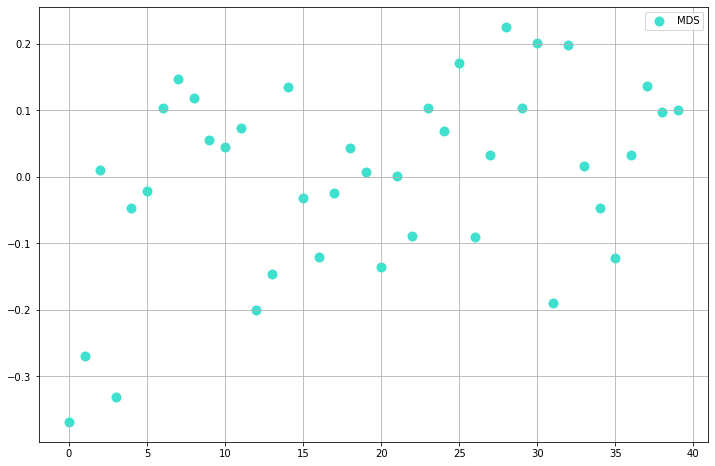

In [119]:
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

mds = manifold.MDS(n_components=1, max_iter=3000, eps=1e-9, 
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_


news = euclidean_distances(pos)

print(f"fit = {np.percentile(news - similarities, [50, 95])}, pos size={np.size(pos, 0)}")

fig = plt.figure(figsize=(12, 8))
plt.grid(True)
#ax = plt.axes([0., 0., 1., 1.])

s = 100
plt.scatter(range(0, np.size(pos,0)), pos[:, 0], color='turquoise', s=s, lw=0, label='MDS')
#plt.scatter(npos[:, 0], npos[:, 1], color='darkorange', s=s, lw=0, label='NMDS')
plt.legend(scatterpoints=1, loc='best', shadow=False)

if False:
    similarities = similarities.max() / (similarities + EPSILON) * 100
    np.fill_diagonal(similarities, 0)
    # Plot the edges
    start_idx, end_idx = np.where(pos)
    # a sequence of (*line0*, *line1*, *line2*), where::
    #            linen = (x0, y0), (x1, y1), ... (xm, ym)
    segments = [[X_true[i, :], X_true[j, :]]
                for i in range(len(pos)) for j in range(len(pos))]
    values = np.abs(similarities)
    lc = LineCollection(segments,
                        zorder=0, cmap=plt.cm.Blues,
                        norm=plt.Normalize(0, values.max()))
    lc.set_array(similarities.flatten())
    lc.set_linewidths(np.full(len(segments), 0.5))
    ax.add_collection(lc)

plt.show()


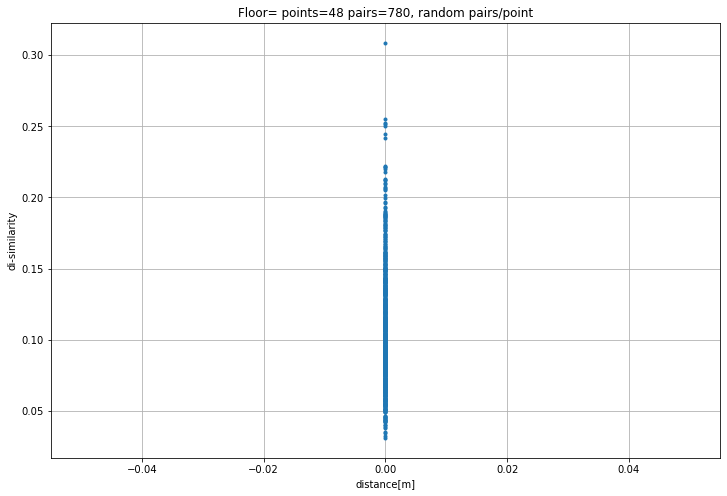

In [125]:
fig =  plt.figure(figsize=(12, 8))        
plt.plot( [r[2] for r in bd], [r[3] for r in bd], ".", label='uji3')
   
plt.xlabel('distance[m]')
plt.ylabel('di-similarity')
plt.grid(True)
plt.title(f"Floor= points={len(uji3[0])} pairs={len(bd)}, random pairs/point")
#plt.xticks(range(0, 10))
#plt.yticks(np.arange(0, 1.1, 0.1))
#plt.legend(loc="upper right",shadow=True, fancybox=True)
plt.show()
#fig.savefig(f"Braycurtis_vs_dist_floor{len(etaje)}_8000pts.pdf", bbox_inches='tight')